In [11]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D # new!
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# hyperparams
output_dir = 'model_output/conv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64
n_unique_words = 5000
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 # new!

# convolutional layer architecture:
n_conv = 256 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture:
n_dense = 256
dropout = 0.2

In [13]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

In [14]:
# pre-process
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

### Convolutional Neural Network Architecture

In [28]:
model = Sequential()

# vector-space embedding:
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

# convolutional layer:
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(Conv1D(n_conv, k_conv, activation='relu'))

model.add(GlobalMaxPooling1D()) # dimensionality reduction

# dense layer
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir):
  os.makedirs(output_dir)


In [32]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.6135 - loss: 0.6110 - val_accuracy: 0.8642 - val_loss: 0.3219
Epoch 2/4
 20/196 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.8730 - loss: 0.2916

KeyboardInterrupt: 

### Evaluation

In [23]:
model.load_weights(output_dir+"/weights.03.keras")

In [25]:
y_hat = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step


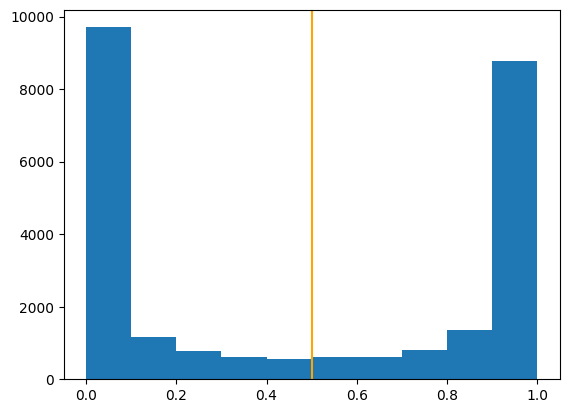

In [26]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [27]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'95.94'